In [1]:
using LinearAlgebra
using DataFrames
using JuMP, Ipopt, Mosek,MosekTools,MathOptInterface

┌ Info: Recompiling stale cache file C:\Users\cilli\.julia\compiled\v1.2\JuMP\DmXqY.ji for JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1240


In [436]:
BranchData = DataFrame(From = [ 1, 1, 2, 3, 3, 4], To = [ 2, 3, 4, 4, 5, 5], 
    R = [ 0.0, 0.023, 0.006, 0.020, 0.0, 0.0], X = [ 0.3, 0.145, 0.032, 0.260, 0.320, 0.500], 
    Gsh = [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Bsh = [ 0.0, 0.040, 0.010, 0.0, 0.0, 0.0], 
    T = [ 1.0, 1.0, 1.0, 1.0, 0.98,1], Tl = [1.0, 1.0, 1.0, 1.0, 0.95, 1.0], Tu = [1.0, 1.0, 1.0, 1.0, 1.05, 1.0],
    ϕ = [ 0.0, 0.0, 0.0, -3.0, 0.0, 0.0], ϕl = [ 0.0, 0.0, 0.0, -30.0, 0.0, 0.0], ϕu = [ 0.0, 0.0, 0.0, 30.0, 0.0, 0.0]
    );
ZshB = [ 0.0+0.0*im 0.0+0.3*im 0.05+0.0*im 0.0+0.0*im 0.0+0.0*im]; 
GshB = [ 0.0 0.0 0.05 0.0 0.0];
BshB = [ 0.0 0.3 0.0 0.0 0.0];
BusNum = 5;
nLine= nrow(BranchData);
BranchData

,From,To,R,X,Gsh,Bsh,T,Tl,Tu,ϕ
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,2,0.0,0.3,0.0,0.0,1.0,1.0,1.0,0.0
2,1,3,0.023,0.145,0.0,0.04,1.0,1.0,1.0,0.0
3,2,4,0.006,0.032,0.0,0.01,1.0,1.0,1.0,0.0
4,3,4,0.02,0.26,0.0,0.0,1.0,1.0,1.0,-3.0
5,3,5,0.0,0.32,0.0,0.0,0.98,0.95,1.05,0.0
6,4,5,0.0,0.5,0.0,0.0,1.0,1.0,1.0,0.0


In [3]:
A = Any[]
for i in 1:BusNum
    Key = (i,i)
    push!(A,Key)
end

In [4]:
A

5-element Array{Any,1}:
 (1, 1)
 (2, 2)
 (3, 3)
 (4, 4)
 (5, 5)

In [5]:
R = BranchData.R; X = BranchData.X; Bsh = BranchData.Bsh; T = BranchData.T; ϕ = BranchData.ϕ;
Y = conj((R + X*im).^-1); G = real(Y); B = imag(Y);
insertcols!(BranchData, 4, Y = round.(Y,digits = 3));
insertcols!(BranchData, 5, G = round.(G,digits = 3));
insertcols!(BranchData, 6, B = round.(B,digits = 3));
select!(BranchData, Not(:R));
select!(BranchData, Not(:X));

In [6]:
BusData = DataFrame(Bus = [ 1, 2, 3, 4, 5], 
    PL = [ 0.0, 0.0, 0.0, 0.90, 0.239], QL = [ 0.0, 0.0, 0.0, 0.400, 0.129], 
    Vmin = [ 1.0, 0.95, 0.95, 0.95, 0.95], Vmax = [ 1.0, 1.05, 1.05, 1.05, 1.05]
    );
GenData = DataFrame(Bus = [ 1, 2, 3, 4, 5], 
    PGmin = [ -Inf, 0.0, 0.10, 0.05, 0.0], PGmax = [ Inf, 0.0, 0.40, 0.40, 0.0], 
    QGmin = [ -Inf, 0.0, -0.2, -0.2, 0.0], QGmax = [ Inf, 0.0, 0.30, 0.20, 0.0]
    );

In [7]:
PgL = Dict{Int64, Float64}();
PgU = Dict{Int64, Float64}();
QgL = Dict{Int64, Float64}();
QgU = Dict{Int64, Float64}();
GenBus = Dict{Int64, Int64}();
for i in 1:size(GenData)[1]
    GenBus[GenData.Bus[i]] = GenData.Bus[i]
    PgL[GenData.Bus[i]]= GenData.PGmin[i]
    PgU[GenData.Bus[i]]= GenData.PGmax[i]
    QgL[GenData.Bus[i]]= GenData.QGmin[i]
    QgU[GenData.Bus[i]]= GenData.QGmax[i]
end

In [8]:
PL = Dict{Int64, Float64}();
QL = Dict{Int64, Float64}();
Vmin = Dict{Int64, Float64}();
Vmax = Dict{Int64, Float64}();
LoadBus = Dict{Int64, Int64}();
for i in 1:size(BusData)[1]
    PL[BusData.Bus[i]]= BusData.PL[i]
    QL[BusData.Bus[i]]= BusData.QL[i]
    Vmin[BusData.Bus[i]]= BusData.Vmin[i]
    Vmax[BusData.Bus[i]]= BusData.Vmax[i]
    LoadBus[BusData.Bus[i]]= BusData.Bus[i]
end

In [9]:
y = Dict{Tuple{Int64, Int64}, ComplexF64}();
g = Dict{Tuple{Int64, Int64}, Float64}();
b = Dict{Tuple{Int64, Int64}, Float64}();
bsh = Dict{Tuple{Int64, Int64}, Float64}();
Tap = Dict{Tuple{Int64, Int64}, Float64}(); 
TapL = Dict{Tuple{Int64, Int64}, Float64}(); 
TapU = Dict{Tuple{Int64, Int64}, Float64}();
Phase = Dict{Tuple{Int64, Int64}, Float64}();
PhaseL = Dict{Tuple{Int64, Int64}, Float64}();
PhaseU = Dict{Tuple{Int64, Int64}, Float64}();


for i in 1:size(BranchData)[1]
    y[(BranchData.From[i], BranchData.To[i])]= BranchData.Y[i]
    g[(BranchData.From[i], BranchData.To[i])]= BranchData.G[i]
    b[(BranchData.From[i], BranchData.To[i])]= BranchData.B[i]
    bsh[(BranchData.From[i], BranchData.To[i])]= BranchData.Bsh[i]
    Tap[(BranchData.From[i], BranchData.To[i])]= BranchData.T[i]
    TapL[(BranchData.From[i], BranchData.To[i])]= BranchData.Tl[i]
    TapU[(BranchData.From[i], BranchData.To[i])]= BranchData.Tu[i]
    Phase[(BranchData.From[i], BranchData.To[i])]= BranchData.ϕ[i]
    PhaseL[(BranchData.From[i], BranchData.To[i])]= BranchData.ϕl[i]
    PhaseU[(BranchData.From[i], BranchData.To[i])]= BranchData.ϕu[i]
end



In [289]:
Self = Tuple{Int64,Int64}[]
for i in 1:BusNum
    Key = (i,i)
    push!(Self,Key)
end
Self;
Trans = collect(keys(y));
K = vcat(Self,Trans);

In [290]:
#=model = nothing
model = Model(with_optimizer(Mosek.Optimizer, linear_solver = "mumps", 
        derivative_test = "second-order",check_derivatives_for_naninf = "yes",
        print_info_string="yes",print_level=0))=#

In [413]:
model = nothing
model = Model(with_optimizer(Mosek.Optimizer))

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Mosek

In [414]:
#@variable(model, T[i = keys(y)]);
#@variable(model, ϕ[i = keys(y)]);
@variable(model, Pg[1:BusNum]);
@variable(model, Qg[1:BusNum]);

In [415]:
@variable(model, W[i = K]             );
@variable(model, WijR[i = Trans]      );
@variable(model, WijI[i = Trans]      );

In [416]:
#=
for (i,j) in keys(y)
    set_start_value(T[(i,j)], Tap[(i,j)])
    set_start_value(ϕ[(i,j)], Phase[(i,j)] * π/180)
end
=#

In [417]:
#=
set_upper_bound(T[(3,5)], TapU[(3,5)] );
set_lower_bound(T[(3,5)], TapL[(3,5)] );

for (i,j) in  filter(x -> x ≠ (3,5), collect(keys(y)))
    fix(T[(i,j)], TapU[(i,j)]);
    fix(T[(i,j)], TapL[(i,j)]);
end
=#

In [418]:
#=
set_upper_bound(ϕ[(3,4)], PhaseU[(3,4)] * π/180);
set_lower_bound(ϕ[(3,4)], PhaseL[(3,4)] * π/180);

for (i,j) in  filter(x -> x ≠ (3,4), collect(keys(y)))
    fix(ϕ[(i,j)], Phase[(i,j)] * π/180)
    fix(ϕ[(i,j)], Phase[(i,j)] * π/180)
end
=#

In [419]:
for i in keys(GenBus)
    set_upper_bound(Pg[i], PgU[i]);
    set_lower_bound(Pg[i], PgL[i]);
    set_upper_bound(Qg[i], QgU[i]);
    set_lower_bound(Qg[i], QgL[i]);
end
delete_upper_bound(Pg[2])
delete_lower_bound(Pg[2])
delete_upper_bound(Pg[5])
delete_lower_bound(Pg[5])
fix(Pg[2],0)
fix(Pg[5],0)
delete_upper_bound(Qg[2])
delete_lower_bound(Qg[2])
delete_upper_bound(Qg[5])
delete_lower_bound(Qg[5])
fix(Qg[2],0)
fix(Qg[5],0)

In [420]:
#=for i in 2:BusNum
    set_upper_bound(V[i], Vmax[i]);
    set_lower_bound(V[i], Vmin[i]);    
end=#

In [421]:
#fix(W[(1,1)],1, force = true)
#fix(WijI[(1,1)],0, force = true)

In [422]:
@objective(model, Min, 0.35*Pg[1] + 0.2*Pg[3] + 0.4*Pg[3]*Pg[3] + 0.3*Pg[4] + 0.5*Pg[4]*Pg[4])

0.4 Pg[3]² + 0.5 Pg[4]² + 0.35 Pg[1] + 0.2 Pg[3] + 0.3 Pg[4]

In [423]:
#@constraint(model,RI_Con[(i,j)=keys(y)], WijR[(i,j)]^2 + WijI[(i,j)]^2 == Wij[(i,j)]^2)
@constraint(model,RI_Con1[ (i,j) = Self], 0 <= W[(i,i)] )
@constraint(model,RI_Con2[(i,j)= K], [W[(i,j)], WijR[(i,j)],WijI[(i,j)]] in SecondOrderCone())
@constraint(model,RI_Con3[(i,j)= K], [W[(i,i)], W[(j,j)], 0,W[(i,j)]] in RotatedSecondOrderCone())
#=@constraint(model, SOC_Con[(i,j) = keys(y) ],
    WijR[(i,j)]*WijR[(i,j)] + WijI[(i,j)]*WijI[(i,j)]<= W[(i,i)]*W[(j,j)] )=#

1-dimensional DenseAxisArray{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (3, 5), (4, 5), (1, 2), (2, 4), (1, 3), (3, 4)]
And data, a 11-element Array{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1}:
 RI_Con3[(1, 1)] : [W[(1, 1)], W[(1, 1)], 0, W[(1, 1)]] in MathOptInterface.RotatedSecondOrderCone(4)
 RI_Con3[(2, 2)] : [W[(2, 2)], W[(2, 2)], 0, W[(2, 2)]] in MathOptInterface.RotatedSecondOrderCone(4)
 RI_Con3[(3, 3)] : [W[(3, 3)], W[(3, 3)], 0, W[(3, 3)]] in MathOptInterface.RotatedSecondOrderCone(4)
 RI_Con3[(4, 4)] : [W[(4, 4)], W[(4, 4)], 0, W[(4, 4)]] in MathOptInterface.RotatedSecondOrderCone(4)
 RI_Con3[(5, 5)] : [W[(5, 5)], W[(5, 5)], 0, W[(5, 5)]] in MathOptInterface.RotatedSecondOrderCone(4)
 RI_Con3[(3, 5)] : [W[(3, 3)], W[(5, 5)], 0, W[(3, 5)]] in MathOptInterface.RotatedSecondOrderCone(4)
 RI_Con3[(4, 5)] : [W[(4, 4)], W[(5, 5)], 0, W[(4,

In [425]:
@constraint(model, V_Con[i = 1:BusNum],
    Vmin[i]*Vmin[i]<=W[(i,i)]<=Vmax[i]*Vmax[i] ) 

5-element Array{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1}:
 V_Con[1] : W[(1, 1)] in [1.0, 1.0]      
 V_Con[2] : W[(2, 2)] in [0.9025, 1.1025]
 V_Con[3] : W[(3, 3)] in [0.9025, 1.1025]
 V_Con[4] : W[(4, 4)] in [0.9025, 1.1025]
 V_Con[5] : W[(5, 5)] in [0.9025, 1.1025]

In [426]:
δL = -30*π/180; δU = 30*π/180;
@constraint(model, δL_Con[(i,j)=keys(y)],
    tan(δL)*(WijR[(i,j)])<= WijI[(i,j)]
    )  
@constraint(model, δU_Con[(i,j)=keys(y)],
    WijI[(i,j)]<=tan(δU)*(WijR[(i,j)])
    )     

1-dimensional DenseAxisArray{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(3, 5), (4, 5), (1, 2), (2, 4), (1, 3), (3, 4)]
And data, a 6-element Array{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1}:
 δU_Con[(3, 5)] : WijI[(3, 5)] - 0.5773502691896257 WijR[(3, 5)] <= 0.0
 δU_Con[(4, 5)] : WijI[(4, 5)] - 0.5773502691896257 WijR[(4, 5)] <= 0.0
 δU_Con[(1, 2)] : WijI[(1, 2)] - 0.5773502691896257 WijR[(1, 2)] <= 0.0
 δU_Con[(2, 4)] : WijI[(2, 4)] - 0.5773502691896257 WijR[(2, 4)] <= 0.0
 δU_Con[(1, 3)] : WijI[(1, 3)] - 0.5773502691896257 WijR[(1, 3)] <= 0.0
 δU_Con[(3, 4)] : WijI[(3, 4)] - 0.5773502691896257 WijR[(3, 4)] <= 0.0

In [427]:
@expression(model, ActivePFij[(i,j) = keys(y)], 
  (1/(Tap[(i,j)]*Tap[(i,j)]))*( g[(i,j)]                                       )*(W[(i,i)]   ) -
  (1/(Tap[(i,j)]         ))*( g[(i,j)]*cos(Phase[(i,j)]) - b[(i,j)]*sin(Phase[(i,j)]))*(WijR[(i,j)]) +
  (1/(Tap[(i,j)]         ))*(-g[(i,j)]*sin(Phase[(i,j)]) - b[(i,j)]*cos(Phase[(i,j)]))*(WijI[(i,j)])
                            )

1-dimensional DenseAxisArray{GenericAffExpr{Float64,VariableRef},1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(3, 5), (4, 5), (1, 2), (2, 4), (1, 3), (3, 4)]
And data, a 6-element Array{GenericAffExpr{Float64,VariableRef},1}:
 0 W[(3, 3)] - 3.188775510204082 WijI[(3, 5)]                                       
 0 W[(4, 4)] - 2 WijI[(4, 5)]                                                       
 0 W[(1, 1)] - 3.333 WijI[(1, 2)]                                                   
 5.66 W[(2, 2)] - 5.66 WijR[(2, 4)] - 30.189 WijI[(2, 4)]                           
 1.067 W[(1, 1)] - 1.067 WijR[(1, 3)] - 6.727 WijI[(1, 3)]                          
 0.294 W[(3, 3)] - 0.24858511682040124 WijR[(3, 4)] + 3.827220589369704 WijI[(3, 4)]

In [428]:
@expression(model, ActivePFji[(i,j) = keys(y)],
                          ( g[(i,j)]                                       )*(W[(j,j)]   ) -
  (1/(Tap[(i,j)]         ))*( g[(i,j)]*cos(Phase[(i,j)]) + b[(i,j)]*sin(Phase[(i,j)]))*(WijR[(i,j)]) -
  (1/(Tap[(i,j)]         ))*( g[(i,j)]*sin(Phase[(i,j)]) - b[(i,j)]*cos(Phase[(i,j)]))*(WijI[(i,j)])
                            )

1-dimensional DenseAxisArray{GenericAffExpr{Float64,VariableRef},1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(3, 5), (4, 5), (1, 2), (2, 4), (1, 3), (3, 4)]
And data, a 6-element Array{GenericAffExpr{Float64,VariableRef},1}:
 0 W[(5, 5)] + 3.188775510204082 WijI[(3, 5)]                                       
 0 W[(5, 5)] + 2 WijI[(4, 5)]                                                       
 0 W[(2, 2)] + 3.333 WijI[(1, 2)]                                                   
 5.66 W[(4, 4)] - 5.66 WijR[(2, 4)] + 30.189 WijI[(2, 4)]                           
 1.067 W[(3, 3)] - 1.067 WijR[(1, 3)] + 6.727 WijI[(1, 3)]                          
 0.294 W[(4, 4)] + 0.8307007048214632 WijR[(3, 4)] - 3.7442420246305024 WijI[(3, 4)]

In [429]:
@constraint(model, ActiveBranch[i = 1:BusNum],Pg[i]-PL[i] == 
sum(ActivePFij[(i,j)] for (i,j) in keys(filter(p -> p.first[1] == i,g))) + 
sum(ActivePFji[(i,j)] for (i,j) in keys(filter(p -> p.first[2] == i,g)))
    ) 

5-element Array{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1}:
 ActiveBranch[1] : Pg[1] + 3.333 WijI[(1, 2)] - 1.067 W[(1, 1)] + 1.067 WijR[(1, 3)] + 6.727 WijI[(1, 3)] == 0.0                                                                                
 ActiveBranch[2] : Pg[2] - 5.66 W[(2, 2)] + 5.66 WijR[(2, 4)] + 30.189 WijI[(2, 4)] - 3.333 WijI[(1, 2)] == 0.0                                                                                 
 ActiveBranch[3] : Pg[3] + 3.188775510204082 WijI[(3, 5)] - 1.361 W[(3, 3)] + 0.24858511682040124 WijR[(3, 4)] - 3.827220589369704 WijI[(3, 4)] + 1.067 WijR[(1, 3)] - 6.727 WijI[(1, 3)] == 0.0
 ActiveBranch[4] : Pg[4] + 2 WijI[(4, 5)] - 5.954 W[(4, 4)] + 5.66 WijR[(2, 4)] - 30.189 WijI[(2, 4)] - 0.8307007048214632 WijR[(3, 4)] + 3.7442420246305024 WijI[(3, 4)] == 0.9                
 ActiveBranch[5] : Pg[5] - 3.188775510204082 WijI[(3, 5)] - 2 WijI[(4, 5)] == 0.239                                                             

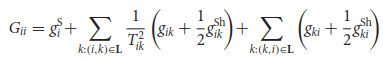

In [430]:
@expression(model, ReActivePFij[(i,j) = keys(y)], 
  (1/(Tap[(i,j)]*Tap[(i,j)]))*(-b[(i,j)]-bsh[(i,j)]/2                                )*(W[(i,i)]                ) -
  (1/(Tap[(i,j)]           ))*(-b[(i,j)]*cos(Phase[(i,j)]) - g[(i,j)]*sin(Phase[(i,j)]))*(WijR[(i,j)]           ) -
  (1/(Tap[(i,j)]           ))*( g[(i,j)]*cos(Phase[(i,j)]) - b[(i,j)]*sin(Phase[(i,j)]))*(WijI[(i,j)]           )
                            )

1-dimensional DenseAxisArray{GenericAffExpr{Float64,VariableRef},1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(3, 5), (4, 5), (1, 2), (2, 4), (1, 3), (3, 4)]
And data, a 6-element Array{GenericAffExpr{Float64,VariableRef},1}:
 -3.2538525614327365 W[(3, 3)] + 3.188775510204082 WijR[(3, 5)]                      
 -2 W[(4, 4)] + 2 WijR[(4, 5)]                                                       
 -3.333 W[(1, 1)] + 3.333 WijR[(1, 2)]                                               
 -30.194 W[(2, 2)] + 30.189 WijR[(2, 4)] - 5.66 WijI[(2, 4)]                         
 -6.747 W[(1, 1)] + 6.727 WijR[(1, 3)] - 1.067 WijI[(1, 3)]                          
 -3.824 W[(3, 3)] - 3.827220589369704 WijR[(3, 4)] - 0.24858511682040124 WijI[(3, 4)]

In [431]:
@expression(model, ReActivePFji[(i,j) = keys(y)],
                            (-b[(i,j)]-bsh[(i,j)]/2                                  )*(W[(j,j)]                ) -
  (1/(Tap[(i,j)]         ))*( g[(i,j)]*sin(Phase[(i,j)]) - b[(i,j)]*cos(Phase[(i,j)]))*(WijR[(i,j)]             ) +
  (1/(Tap[(i,j)]         ))*( b[(i,j)]*sin(Phase[(i,j)]) + g[(i,j)]*cos(Phase[(i,j)]))*(WijI[(i,j)]             )
                            )

1-dimensional DenseAxisArray{GenericAffExpr{Float64,VariableRef},1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(3, 5), (4, 5), (1, 2), (2, 4), (1, 3), (3, 4)]
And data, a 6-element Array{GenericAffExpr{Float64,VariableRef},1}:
 -3.125 W[(5, 5)] + 3.188775510204082 WijR[(3, 5)]                                   
 -2 W[(5, 5)] + 2 WijR[(4, 5)]                                                       
 -3.333 W[(2, 2)] + 3.333 WijR[(1, 2)]                                               
 -30.194 W[(4, 4)] + 30.189 WijR[(2, 4)] + 5.66 WijI[(2, 4)]                         
 -6.747 W[(3, 3)] + 6.727 WijR[(1, 3)] + 1.067 WijI[(1, 3)]                          
 -3.824 W[(4, 4)] - 3.7442420246305024 WijR[(3, 4)] - 0.8307007048214632 WijI[(3, 4)]

In [432]:
@constraint(model, ReActiveBranch[i = 1:BusNum],Qg[i]-QL[i] == 
sum(ReActivePFij[(i,j)] for (i,j) in keys(filter(p -> p.first[1] == i,b))) + 
sum(ReActivePFji[(i,j)] for (i,j) in keys(filter(p -> p.first[2] == i,b)))
    ) 

5-element Array{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1}:
 ReActiveBranch[1] : Qg[1] + 10.08 W[(1, 1)] - 3.333 WijR[(1, 2)] - 6.727 WijR[(1, 3)] + 1.067 WijI[(1, 3)] == 0.0                                                                                             
 ReActiveBranch[2] : Qg[2] + 33.527 W[(2, 2)] - 30.189 WijR[(2, 4)] + 5.66 WijI[(2, 4)] - 3.333 WijR[(1, 2)] == 0.0                                                                                            
 ReActiveBranch[3] : Qg[3] + 13.824852561432737 W[(3, 3)] - 3.188775510204082 WijR[(3, 5)] + 3.827220589369704 WijR[(3, 4)] + 0.24858511682040124 WijI[(3, 4)] - 6.727 WijR[(1, 3)] - 1.067 WijI[(1, 3)] == 0.0
 ReActiveBranch[4] : Qg[4] + 36.018 W[(4, 4)] - 2 WijR[(4, 5)] - 30.189 WijR[(2, 4)] - 5.66 WijI[(2, 4)] + 3.7442420246305024 WijR[(3, 4)] + 0.8307007048214632 WijI[(3, 4)] == 0.4                            
 ReActiveBranch[5] : Qg[5] + 5.125 W[(5, 5)] - 3.188775510204082 WijR[(3, 5)] - 2 Wi

In [433]:
optimize!(model)
objective_value(model)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 80              
  Cones                  : 23              
  Scalar variables       : 92              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 20
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimiza

-0.31450755622028415

In [435]:
model

A JuMP Model
Minimization problem with:
Variables: 43
Objective function type: GenericQuadExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 10 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 17 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.Interval{Float64}`: 5 constraints
`Array{VariableRef,1}`-in-`MathOptInterface.SecondOrderCone`: 11 constraints
`Array{GenericAffExpr{Float64,VariableRef},1}`-in-`MathOptInterface.RotatedSecondOrderCone`: 11 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 6 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 6 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Mosek
Names registered in the model: ActiveBranch, ActivePFij, ActivePFji, Pg, Qg, RI_Con1, RI_Con2, RI_Con3, ReActiveBranch, ReActi

In [434]:
P_G = value.(Pg)
Q_G = value.(Qg)
BusResults = DataFrame(Pg = P_G, Qg = Q_G)

,Pg,Qg
,Float64,Float64
1,-1.08453,-0.929006
2,-0.0,7.10543e-15
3,0.179615,-0.199999
4,0.0500004,0.2
5,-0.0,4.44089e-16


In [44]:
T_ϕ  = rad2deg.(value.(ϕ))
T_ϕV = rad2deg.(value.(ϕ)).data
K11 = (collect(T_ϕ.axes[1]));K11 = first.(K11);
K12 = (collect(T_ϕ.axes[1]));K12 = last.(K12);
T_TV = (value.(T)).data
K21 = (collect(T_ϕ.axes[1]));K11 = first.(K11);
K22 = (collect(T_ϕ.axes[1]));K12 = last.(K12);
BranchResults = DataFrame(From = K11, To = K12, ϕ = T_ϕV , T = T_TV)

,From,To,ϕ,T
,Int64,Int64,Float64,Float64
1,3,5,0.0,0.998197
2,4,5,0.0,1.0
3,1,2,0.0,1.0
4,2,4,0.0,1.0
5,1,3,0.0,1.0
6,3,4,-16.8959,1.0


In [156]:
value.(W)


1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, Any[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]
And data, a 5-element Array{Float64,1}:
 1.0               
 1.1024999997242033
 0.9024999999891558
 0.95639813443374  
 1.1025000000197693

In [157]:
value.(WijR)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(3, 5), (4, 5), (1, 2), (2, 4), (1, 3), (3, 4)]
And data, a 6-element Array{Float64,1}:
 1.0590032798445883   
 1.0721943879671088   
 1.458253302913104    
 1.0591309278585035   
 1.3394885595303023   
 4.334910506702795e-12

In [158]:
value.(WijI)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(3, 5), (4, 5), (1, 2), (2, 4), (1, 3), (3, 4)]
And data, a 6-element Array{Float64,1}:
 -0.3133062938573134  
  0.619031718519581   
  0.2801737020807963  
 -0.022801351567456996
  0.10378053276247282 
 -7.05529234196389e-12